<a href="https://colab.research.google.com/github/zeromath/RootInsurance/blob/master/make_competitors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 

In [0]:
import torch 
from torch.autograd import Variable 
from torch import optim
from itertools import combinations
import matplotlib.pyplot as plt

# Define the ```InsuranceCompany``` class

In [0]:
class InsuranceCompany: 

    def __init__(self): 
        self.param_ = dict()
        # Let the bid be uniformly in mean-span, mean+span
        self.param_['mean'] = 10 
        self.param_['span'] = 2
    
    def set_param(self, **kwargs):
        # Use this function to set parameters like married, num_of_vehicles etc 
        for k,v in kwargs.items(): 
            self.param_[k] = v 

    def get_param(self): 
        return self.param_

    def bid(self): 
        bid_mean = self.param_['mean']
        bid_span = self.param_['span']
        return (2*bid_span)*np.random.rand() + bid_mean - bid_span
        
        

## Function signature 

The sample use of this function is as follows. Note that parameters like ```num_of_drivers``` is used to distinguish between instances of the class, but do NOT affect the bedding behaviors. In practice, we only change the parameters like ```mean``` and ```span``` to train the models to fit to currently observed behaviors. 

In [0]:
# Initialize the insurance company object like this: 
ins = InsuranceCompany()
ins.set_param(num_of_driver=2)
print(ins.get_param())

{'mean': 10, 'span': 2, 'num_of_driver': 2}


In [0]:
# Ask the company to bid like this: 
ins.bid()

8.50293991225879

In [0]:
# Create our company who only bids $10
acme_company = InsuranceCompany()
acme_company.set_param(span=0)

In [0]:
# test that acme_company only bids $10 
acme_company.bid()

10.0

# Define the Environment class 

This is the class that simulates the bidding environment. Our company, together with four competing agents will each give a price, and the environment will compute the rank for our agent. Based on the rank, the environment returns a reward. 

$$Reward = \left\{ \begin{array}{ll} P-bid, & \text{if policy sold}  \\ -bid, & \text{if clicked but not sold} \\
0, & \text{if not clicked}\end{array} \right.$$

Each outcome's probability will be determined by the distribution of our given data. 

In [0]:
class BidEnvironment: 
    def __init__(self): 
        self.param_ = dict()
        # sale_prob_ = []
        # click_prob_ = []
        # P = 20.0 

    def set_param(self, **kwargs):
        ''' Use this function to set parameters
        '''
        for k,v in kwargs.items(): 
            self.param_[k] = v

    def rank_bid(self, bids): 
        ''' Computes the rank given bids 
        Args:
            bids (list): list of bids 
        Returns: 
            rank (list): rank of bids. rank[i] = ranking of i-th bid in bids 
        '''
        bids_sorted = sorted( [(bid,company) for company,bid in enumerate(bids)] , reverse=True)
        rank = [0]*5
        for r, pair in enumerate(bids_sorted):
            rank[pair[1]] = r 
        return rank 


    def gen_reward(self, bid, rank): 
        ''' Generates rewards and selling status according to rank
        Args:
            bid (float): our bid 
            rank (float): our rank 
        Returns:
            rewards (float): rewards 
            click (int): 1 iff clicked 
            sold (int): 1 iff sold 
        '''
        prob_clicking = self.param_['click_prob_'][rank]
        prob_selling = self.param_['sale_prob_'][rank]
        outcome = np.random.rand()
        if outcome < prob_selling: 
            # policy sold! 
            return (self.param_['P']-bid, 1,1)
        if outcome < prob_clicking: 
            # clicked but not sold 
            return (-bid, 1,0)
        # did not click 
        return (0,0,0)



We can initialize the environment like so: 

In [0]:
# Environment for, say no insurance, 1 driver, 1 vehicle, married
env = BidEnvironment()
# Infer unknown probability from the whole distribution 
env.set_param(click_prob_=[0.509, 0.215, 0.148, 0.038, 0.02], 
              sale_prob_=[0.2866, 0.1179, 0.06329, 0.031847, 0.009482], 
              P = 0) 

# Find distribution of competitors that fit our model

Notice that the combination of companies to make our sample distribution is certainly not unique. Here we fix the ```span``` parameters and tune the ```mean``` to fit to our model. There are 16 different combinations of customer categories, so we have to tune the model 16 times. 

In all models, we define the loss to be $L^2$ norm of the actual distribution and the ideal distribution: 

In [0]:
def mse(outcome, result): 
    '''
    Args: 
        outcome (pytorch Variable): some given distribution of ranking 
        result (pytorch Variable): desired distribution of ranking 
    Returns: 
        L^2 norm of error (pytorch Variable): ||outcome-result||_{L^2}^2
    '''
    # outcome = outcome predicted by model 
    # result = actual result 
    
    return torch.mean( (outcome-result).pow(2) )

def forward(x): 
    '''
    Args: 
        x (pytorch Variable): the input prob. x[i] = i-th competitor's probability of bidding more
            than $10 
    Returns:
        outcome (pytorch Variable): the resulting distribution of ranking. 
                                    outcome[i] = prob of [$10 rank=i+1]
    '''
    # Forward pass 
    outcome = torch.tensor([1.,1.,1.,1., 1.])
    outcome[0] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[1] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(x[3]) \
                 + (1.-x[0])*(1.-x[1])*(x[2])*(1.-x[3]) \
                 + (1.-x[0])*(x[1])*(1.-x[2])*(1.-x[3]) \
                 + (x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[3] = x[0]*x[1]*x[2]*(1.0-x[3]) \
                 + x[0]*x[1]*(1.0-x[2])*x[3] \
                 + x[0]*(1.0-x[1])*x[2]*x[3] \
                 + (1.0-x[0])*x[1]*x[2]*x[3]
    outcome[4] = x[0]*x[1]*x[2]*x[3]
    outcome[2] = 1-outcome[0]-outcome[1]-outcome[3]-outcome[4]
    return outcome 

We can automatically train the competitors to generate the desired distribution. 

In [0]:
def train(known_result, epochs=1000): 
    # Define conditions for model 
    desired_result = Variable(torch.tensor(known_result), requires_grad=False)
    prob = Variable(torch.rand(4), requires_grad=True)

    # model settings 
    learning_rate = 0.001
    # Set up optimizer 
    optim = torch.optim.SGD([prob], lr=learning_rate, momentum=.9)
    # Record log of training 
    loss_history = []

    for e in range(epochs): 
        optim.zero_grad()
        # print('Iteration', e)

        # Forward pass 
        outcome = forward(prob)

        # Compute loss 
        loss = mse(desired_result, outcome)

        # Record loss history 
        loss_history.append(loss.data)

        # Backward pass 
        loss.backward()
        optim.step()

        # Print loss 
        # print(' Training loss:', loss.data)
    plt.plot(loss_history)
    return prob

In [0]:
# Record the training results
## Keys in trained_prob are of the form 'no,1d,2v,m'
## no = not currently insured 
## 1d = 1 driver 
## 2v = 2 vehicles 
## m  = married

trained_prob = dict()

## not currrently insured, 1 driver, 2 vehicles, married

About 20% of the entire population falls into this category. We are mostly ranked #5 in this category, but the turnover rate is high (about 50% who clicked on the ad actually made the purchase, although we are ranked #3). 

Currently, we have the following ranking distribution:

Rank 3 -- 18.4% 

Rank 4 -- 31.5% 

Rank 5 -- 50.1%



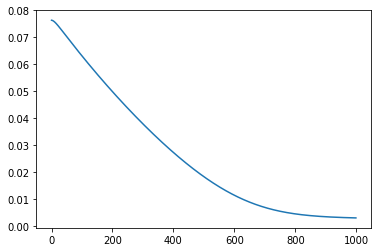

In [0]:
trained_prob['no,1d,2v,m'] = train(np.array([0,0,0.184, 0.315, 0.501]))

## not currrently insured, 1 driver, 1 vehicle, married

About 7.5% of the entire population falls into this category. 

Currently, our ranking is: 
```0.210456	0.261394	0.317694	0.210456	0.000000```


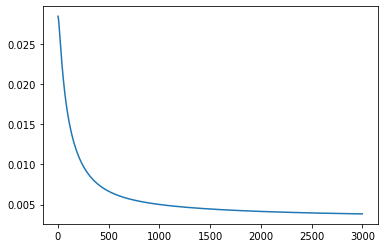

In [17]:
trained_prob['no,1d,1v,m'] = train(np.array([0.21,0.26,0.32,0.21,0.0]), 3000)

## not currrently insured, 2 drivers, 1 vehicle, unmarried

About .75% of the entire population falls into this category. 

Currently, our ranking is: 
```0.495606	0.305800	0.198594	0.000000	0.000000```


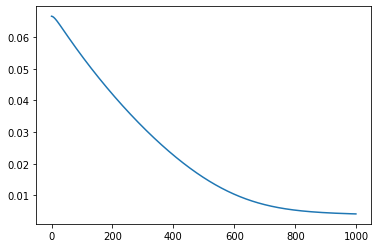

In [0]:
trained_prob['no,2d,1v,m'] = train(np.array([0.495,0.305, 0.20,0.0,0.0]), 2000)

# Simulate a strategy 

Let's simulate, for instance, not insured, 1 driver, 1 vehicle, married

In [20]:
# Obtain competitor's probability of ranking higher than us 
trained_prob['no,1d,1v,m'].data

tensor([0.4200, 0.3853, 0.5383, 0.3366])

Say their their distributions are uniform with ```span=1```. Then their probabilty of ranking higher than 10 will be $$\frac{(mean+span)-10}{2\cdot span} = p,$$ which means that $$
mean = 10+2p\cdot span - span.
$$

In [26]:
competitors = [None]*4
probs = trained_prob['no,1d,1v,m'].data.numpy()
span=2 
for i in range(4): 
    competitors[i] = InsuranceCompany()
    competitors[i].set_param(span=span, 
                             mean=10+2*probs[i]*span-span)
    print('Set up competitor {}, span={}, mean={}'.format(\
            i, competitors[i].param_['span'], competitors[i].param_['mean']))
    

Set up competitor 0, span=2, mean=9.679808139801025
Set up competitor 1, span=2, mean=9.541260838508606
Set up competitor 2, span=2, mean=10.153361558914185
Set up competitor 3, span=2, mean=9.346580505371094


If we change our bid to \$11, what will be the expected payoff? 

In [0]:
env.set_param(P=30)

In [146]:
# Check the environment's parameters 
env.param_

{'P': 30,
 'click_prob_': [0.509, 0.215, 0.148, 0.038, 0.02],
 'sale_prob_': [0.2866, 0.1179, 0.06329, 0.031847, 0.009482]}

In [0]:
# Simulate bidding 
def simulate(our_bid, num_trials=10000): 
    # Set up parameters 
    total_rewards = 0 
    total_sold = 0 
    rank_history = [0]*5 
    
    # Simulate each trial 
    for t in range(num_trials):
        # Let all competitors bid 
        bids = [competitors[i].bid() for i in range(4)]
        our_rank = env.rank_bid([our_bid]+bids)[0]
        this_reward, clicked, sold = env.gen_reward(our_bid, our_rank)
        if sold: 
            total_sold += 1
        total_rewards += this_reward
        rank_history[our_rank] += 1
    return total_rewards, total_sold, rank_history

Rewards = 1845.0
Sold = 188


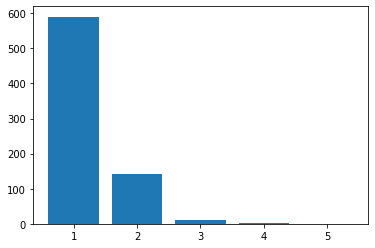

In [155]:
our_bid = 11.5
num_of_customers_in_category = 746
total_rewards, total_sold, rank_history = simulate(our_bid, num_of_customers_in_category)
print('Rewards = {}\nSold = {}'.format(total_rewards, total_sold))
f = plt.figure()
plt.bar([1,2,3,4,5], rank_history)
plt.show()

In [0]:
x